In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "soccer"

In [2]:
library(reshape2)


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [3]:
library("RSQLite")

## connect to db
con <- dbConnect(drv=RSQLite::SQLite(), dbname="../input/soccer/database.sqlite")

## list all tables
tables <- dbListTables(con)

## exclude sqlite_sequence (contains table information)
tables <- tables[tables != "sqlite_sequence"]

lDataFrames <- vector("list", length=length(tables))

## create a data.frame for each table
for (i in seq(along=tables)) {
  lDataFrames[[i]] <- dbGetQuery(conn=con, statement=paste("SELECT * FROM '", tables[[i]], "'", sep=""))
}



In [83]:
# create dataframes
country <-  data.frame(lDataFrames[1])
country <- select(country, id, name) %>% rename(country_id = id)  %>% rename(country_name = name)   # use country_id as key for join
match <- data.frame(lDataFrames[3])

In [84]:
match <- match %>% select(match_api_id,country_id, season,home_team_api_id,home_team_goal, away_team_goal)
match$home_score <- (match$home_team_goal - match$away_team_goal)
match$away_score <- (match$away_team_goal - match$home_team_goal)

In [85]:
match <- left_join(match, country, by = "country_id")
head(match)

,match_api_id,country_id,season,home_team_api_id,home_team_goal,away_team_goal,home_score,away_score,country_name
,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<chr>
1,492473,1,2008/2009,9987,1,1,0,0,Belgium
2,492474,1,2008/2009,10000,0,0,0,0,Belgium
3,492475,1,2008/2009,9984,0,3,-3,3,Belgium
4,492476,1,2008/2009,9991,5,0,5,-5,Belgium
5,492477,1,2008/2009,7947,1,3,-2,2,Belgium
6,492478,1,2008/2009,8203,1,1,0,0,Belgium


In [88]:
scoring_win <- function(x){  
    if (x>0){
        ans = 1
    }else{
        ans = 0}
    return(ans)
    }
match$home_win_rate <- as.numeric(lapply(match$home_score,FUN=scoring_win))
match$away_win_rate <- as.numeric(lapply(match$away_score,FUN=scoring_win))
match <- match %>% select(season,country_name,home_win_rate,away_win_rate)
head(match)

,season,country_name,home_win_rate,away_win_rate
,<chr>,<chr>,<dbl>,<dbl>
1,2008/2009,Belgium,0,0
2,2008/2009,Belgium,0,0
3,2008/2009,Belgium,0,1
4,2008/2009,Belgium,1,0
5,2008/2009,Belgium,0,1
6,2008/2009,Belgium,0,0


In [89]:
match15 = with(match, match[(season=='2015/2016'),])
match15 <- match15 %>% 
            group_by(country_name) %>% 
               summarise_at(vars("home_win_rate", "away_win_rate"), mean)
match15$home_adv <-  (match15$home_win_rate - match15$away_win_rate)*100
match15[2,1] = 'UK'
match15

country_name,home_win_rate,away_win_rate,home_adv
<chr>,<dbl>,<dbl>,<dbl>
Belgium,0.4791667,0.2750000,20.416667
UK,0.4131579,0.3052632,10.789474
France,0.4210526,0.2947368,12.631579
Germany,0.4411765,0.3267974,11.437908
Italy,0.4605263,0.2894737,17.105263
Netherlands,0.4477124,0.3104575,13.725490
Poland,0.3791667,0.3125000,6.666667
Portugal,0.4346405,0.3169935,11.764706
Scotland,0.4078947,0.3640351,4.385965


In [90]:
match8 = with(match, match[(season=='2008/2009'),])
match8 <- match8 %>% 
            group_by(country_name) %>% 
               summarise_at(vars("home_win_rate", "away_win_rate"), mean)
match8$home_adv <-  (match8$home_win_rate - match8$away_win_rate)*100
match8[2,1] = 'UK'
match8

country_name,home_win_rate,away_win_rate,home_adv
<chr>,<dbl>,<dbl>,<dbl>
Belgium,0.4869281,0.2941176,19.28105
UK,0.4552632,0.2894737,16.57895
France,0.4342105,0.2710526,16.31579
Germany,0.4803922,0.2777778,20.26144
Italy,0.5052632,0.2447368,26.05263
Netherlands,0.4803922,0.2712418,20.91503
Poland,0.4958333,0.2583333,23.75000
Portugal,0.4458333,0.2875000,15.83333
Scotland,0.4210526,0.3201754,10.08772


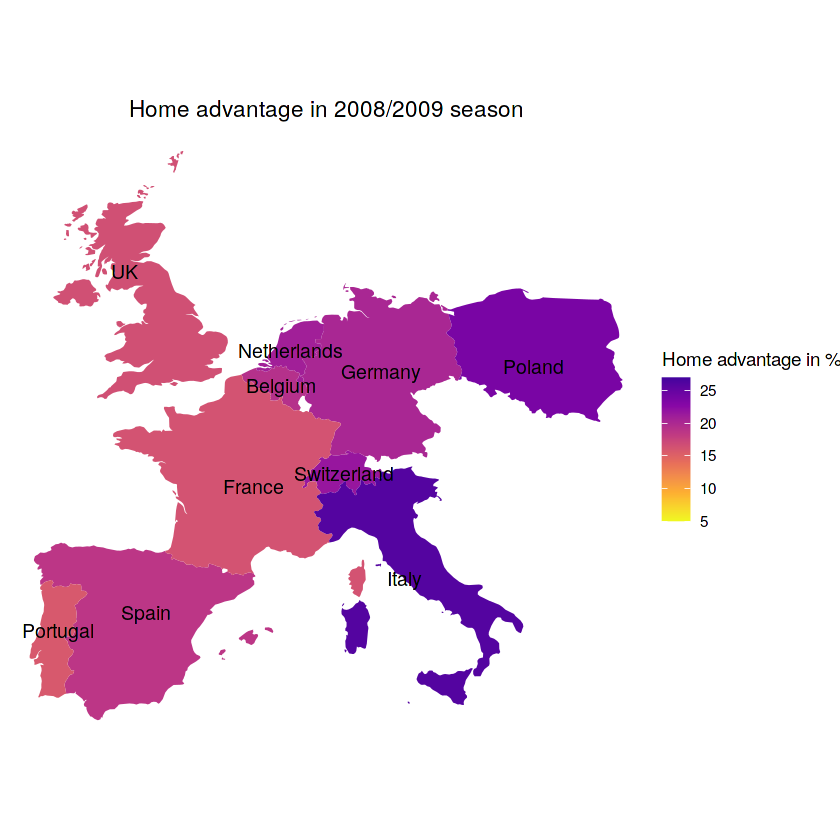

In [182]:
library(ggplot2)
require(maps)

# map of europe
some.eu.countries <- match8$country_name
eur <- map_data("world", region = some.eu.countries) %>% left_join(match8, by = c('region' = 'country_name'))
region.label <- eur %>% 
  group_by(region) %>%
  summarise_each(funs(mean), c(1:2))

ggplot(eur, aes(x = long, y = lat)) +
  geom_polygon(aes(group = group, fill = home_adv))+
  geom_text(aes(label = region), data = region.label,  size = 4, hjust = 0.5, color="black")+
  coord_fixed(1.3) +
  scale_fill_viridis_c(option = "C",direction = -1,alpha = 1,begin = 0.1,end = 1, limits=c(5, 27),guide_legend(title="Home advantage in %"))+
  ggtitle("Home advantage in 2008/2009 season") +
  theme_void()+
  theme(legend.position = "right",plot.title = element_text(hjust = 0.5))



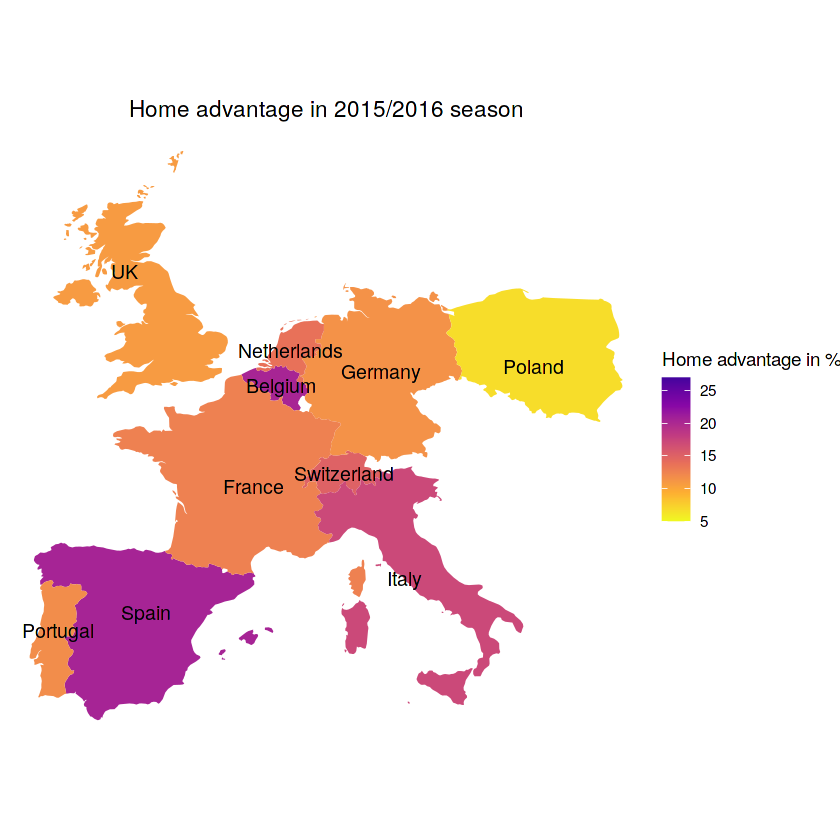

In [181]:
# map of europe
some.eu.countries <- match15$country_name
eur <- map_data("world", region = some.eu.countries) %>% left_join(match15, by = c('region' = 'country_name'))
region.label <- eur %>% 
  group_by(region) %>%
  summarise_each(funs(mean), c(1:2))

ggplot(eur, aes(x = long, y = lat)) +
  geom_polygon(aes(group = group, fill = home_adv))+
  geom_text(aes(label = region), data = region.label,  size = 4, hjust = 0.5, color="black")+
  coord_fixed(1.3) +
  scale_fill_viridis_c(option = "C",direction = -1,alpha = 1,begin = 0.1,end = 1, limits=c(5, 27),guide_legend(title="Home advantage in %"))+
  ggtitle("Home advantage in 2015/2016 season") +
  theme_void()+
  theme(legend.position = "right",plot.title = element_text(hjust = 0.5))

  

[1] "Home advantage in 2008/2009 season"
[1] "Home advantage in 2009/2010 season"


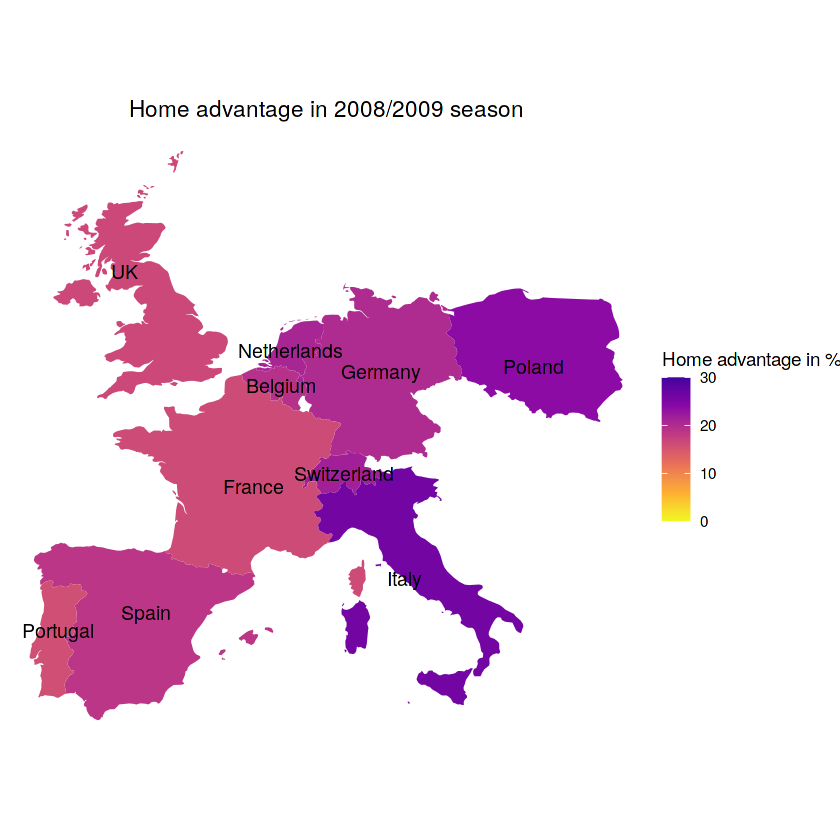

[1] "Home advantage in 2010/2011 season"


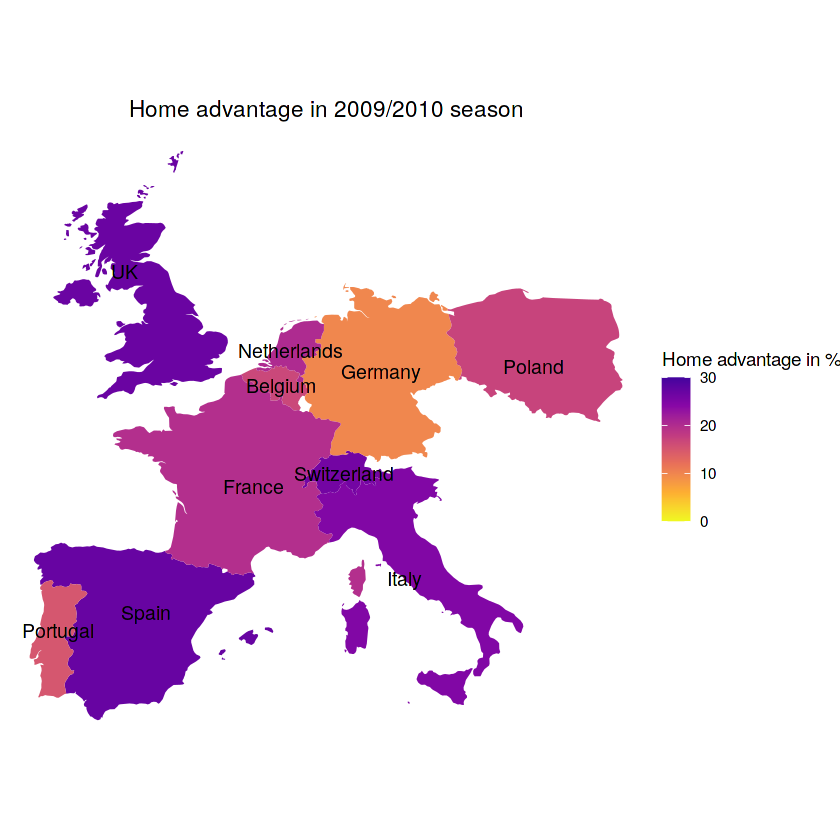

[1] "Home advantage in 2011/2012 season"


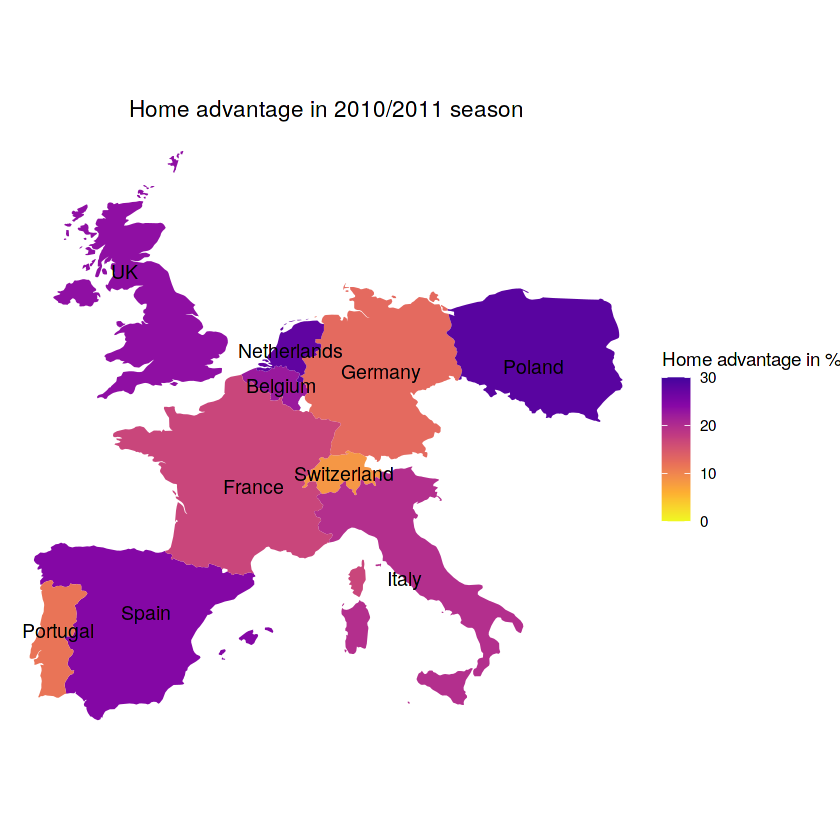

[1] "Home advantage in 2012/2013 season"


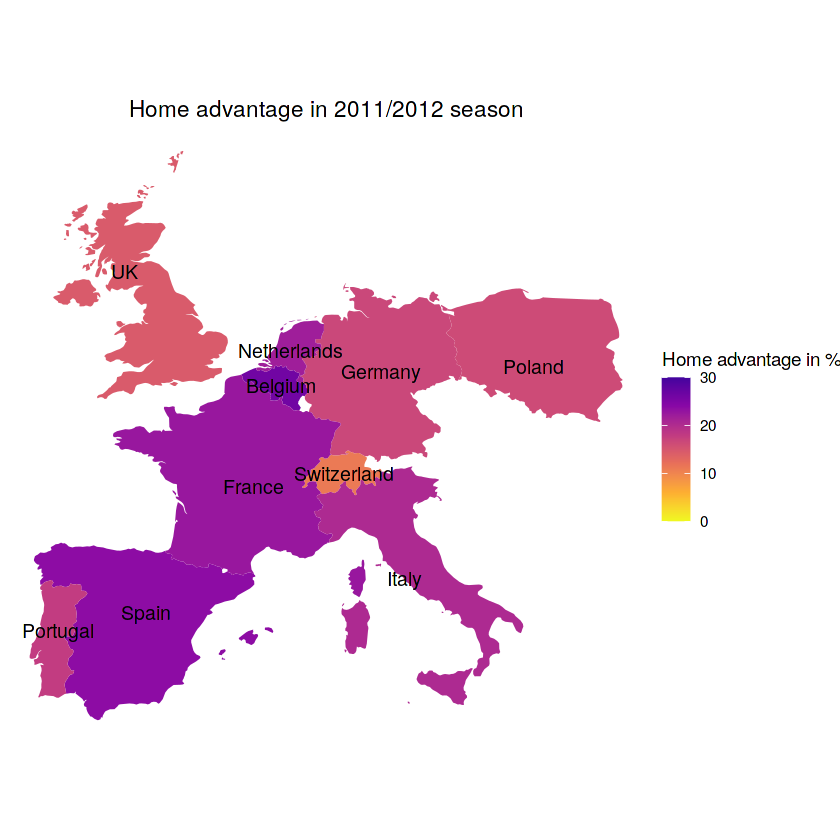

[1] "Home advantage in 2014/2015 season"


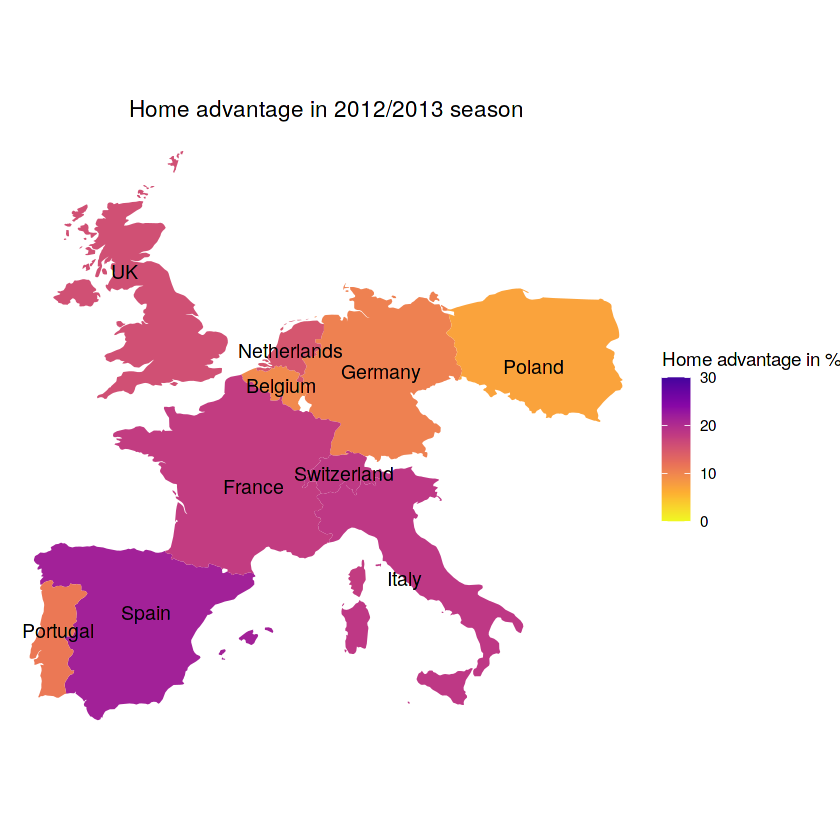

[1] "Home advantage in 2015/2016 season"


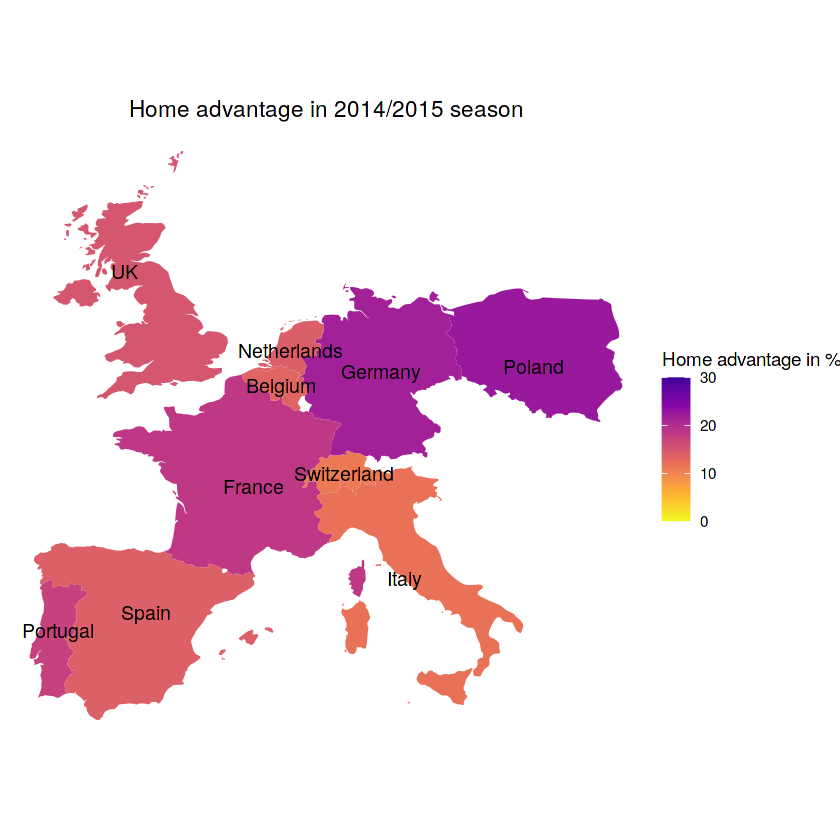

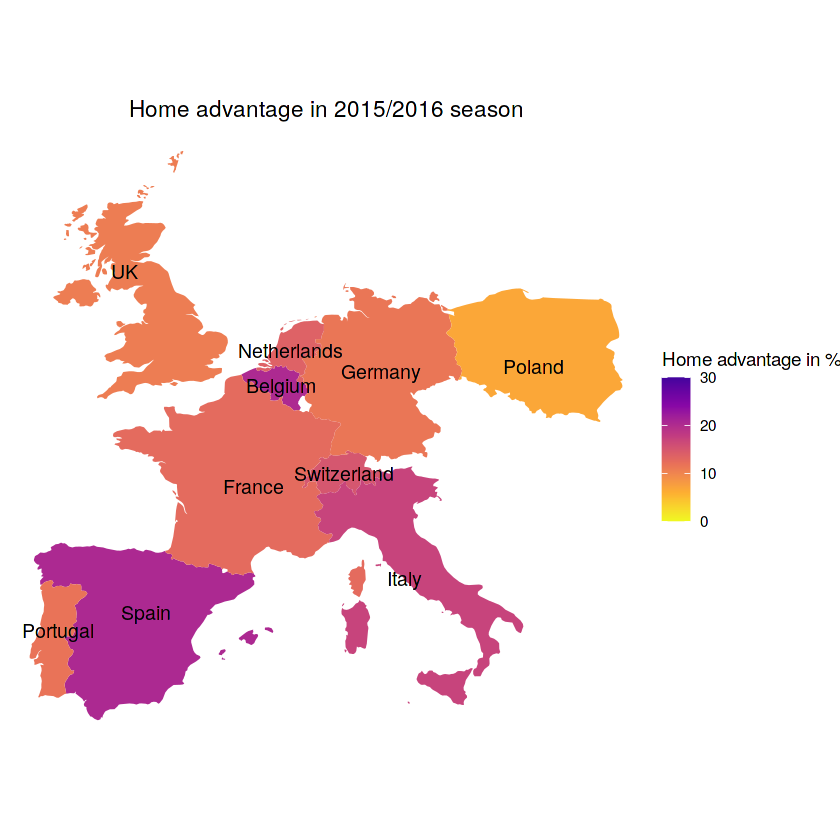

In [188]:
x <- c("2008/2009","2009/2010","2010/2011","2011/2012","2012/2013","2014/2015","2015/2016")
for (val in x) {

    title = sprintf("Home advantage in %s season", val)
    print(title)
    match_season = with(match, match[(season==val),])
    match_season <- match_season %>% 
                group_by(country_name) %>% 
                   summarise_at(vars("home_win_rate", "away_win_rate"), mean)
    match_season$home_adv <-  (match_season$home_win_rate - match_season$away_win_rate)*100
    match_season[2,1] = 'UK'

    
    # map of europe
    some.eu.countries <- match_season$country_name
    eur <- map_data("world", region = some.eu.countries) %>% left_join(match_season, by = c('region' = 'country_name'))
    region.label <- eur %>% 
      group_by(region) %>%
      summarise_each(funs(mean), c(1:2))

    my_map <- ggplot(eur, aes(x = long, y = lat)) +
      geom_polygon(aes(group = group, fill = home_adv))+
      geom_text(aes(label = region), data = region.label,  size = 4, hjust = 0.5, color="black")+
      coord_fixed(1.3) +
      scale_fill_viridis_c(option = "C",direction = -1,alpha = 1,begin = 0.1,end = 1, limits=c(0, 30),guide_legend(title="Home advantage in %"))+
      ggtitle(title) +
      theme_void()+
      theme(legend.position = "right",plot.title = element_text(hjust = 0.5))
    
    print(my_map)
}


# Linear Regression

In [232]:
match <- data.frame(lDataFrames[3])
match <- match %>% select(country_id, season,home_team_goal, away_team_goal)
match <- left_join(match, country, by = "country_id") %>% select(-country_id)
match$home_score <- (match$home_team_goal - match$away_team_goal)
match$away_score <- (match$away_team_goal - match$home_team_goal)
scoring_win <- function(x){  
    if (x>0){
        ans = 1
    }else{
        ans = 0}
    return(ans)
    }
match$home_win_rate <- as.numeric(lapply(match$home_score,FUN=scoring_win))
match$away_win_rate <- as.numeric(lapply(match$away_score,FUN=scoring_win))
match <- match %>% 
                group_by(season, country_name) %>% 
                   summarise_at(vars("home_win_rate", "away_win_rate"), mean)
match$home_adv <-  (match$home_win_rate - match$away_win_rate)*100
match <- match %>% select(season,country_name,home_adv)
head(match)

season,country_name,home_adv
<chr>,<chr>,<dbl>
2008/2009,Belgium,19.28105
2008/2009,England,16.57895
2008/2009,France,16.31579
2008/2009,Germany,20.26144
2008/2009,Italy,26.05263
2008/2009,Netherlands,20.91503


In [252]:
match$year =  as.numeric(substr(match$season,1,4))
m <- lm(home_adv ~ year, data = match)

summary(m)


Call:
lm(formula = home_adv ~ year, data = match)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.0011  -3.1032  -0.1943   3.8897  10.3849 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept) 1694.1608   504.3412   3.359  0.00117 **
year          -0.8339     0.2507  -3.326  0.00130 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.389 on 86 degrees of freedom
Multiple R-squared:  0.114,	Adjusted R-squared:  0.1037 
F-statistic: 11.06 on 1 and 86 DF,  p-value: 0.001297


`geom_smooth()` using formula 'y ~ x'



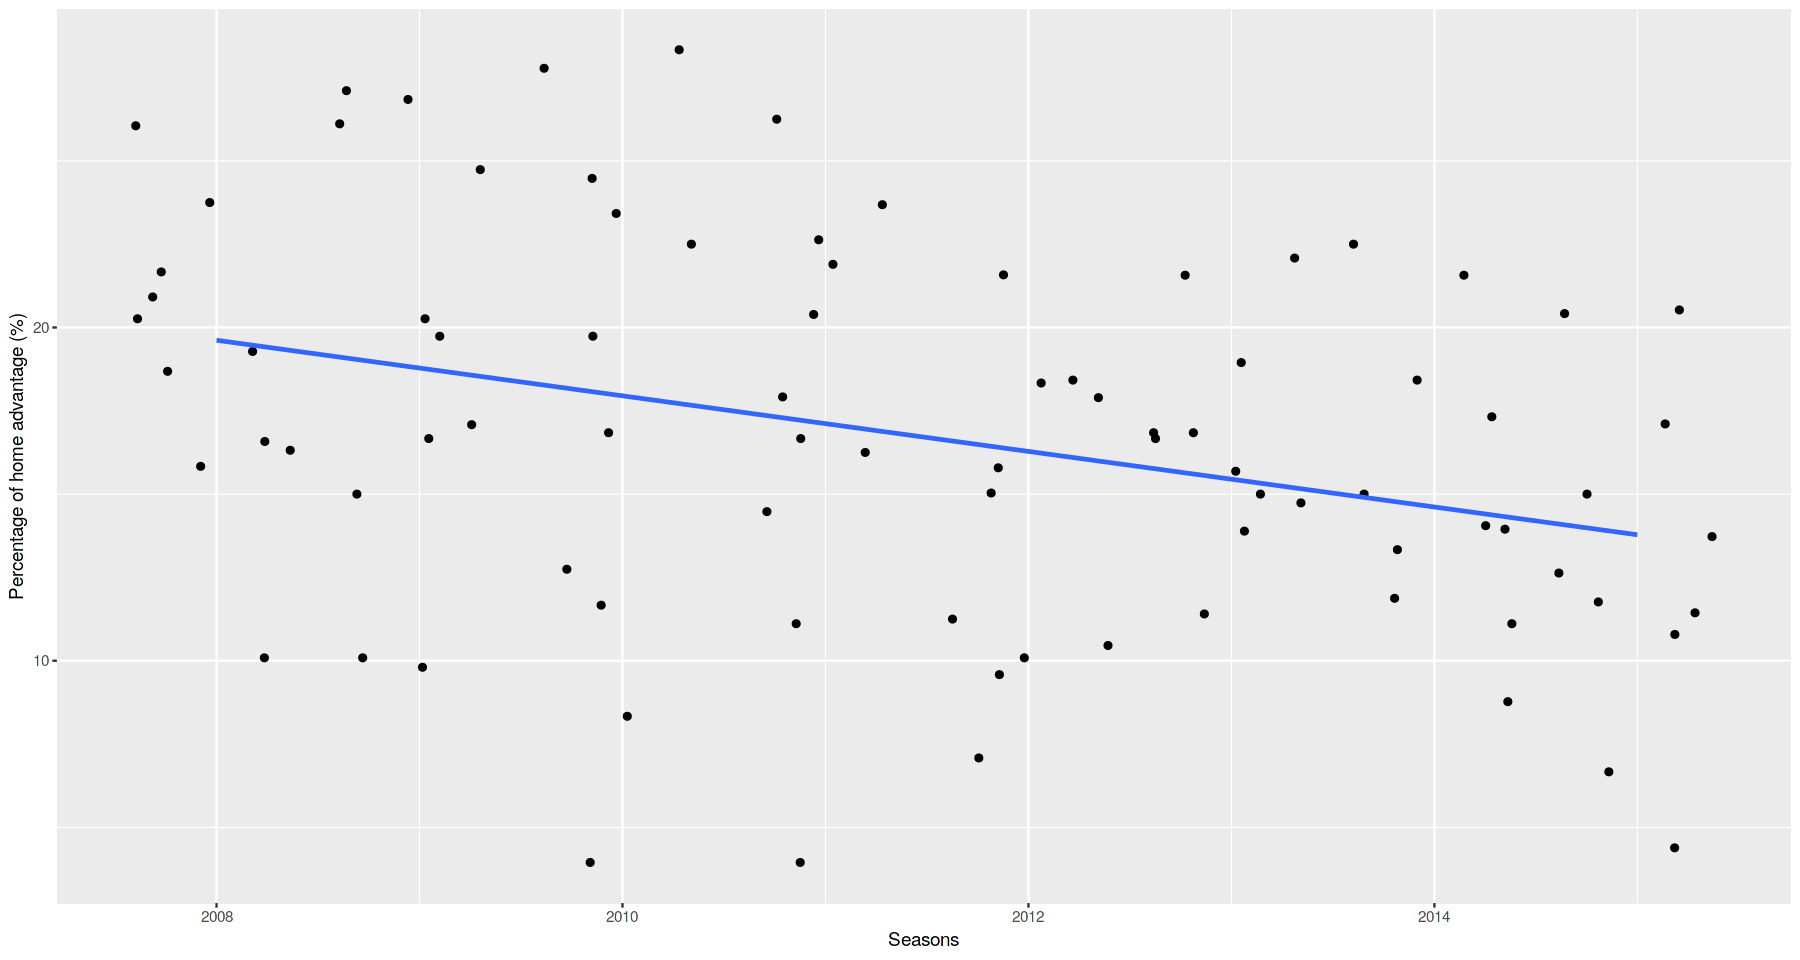

In [245]:
require(ggplot2)
ggplot(match) +
  geom_jitter(aes(year,home_adv),) + 
  geom_smooth(aes(year,home_adv), method=lm, se=FALSE) +
  labs(y = "Percentage of home advantage (%)", x = "Seasons")
#  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


`geom_smooth()` using formula 'y ~ x'



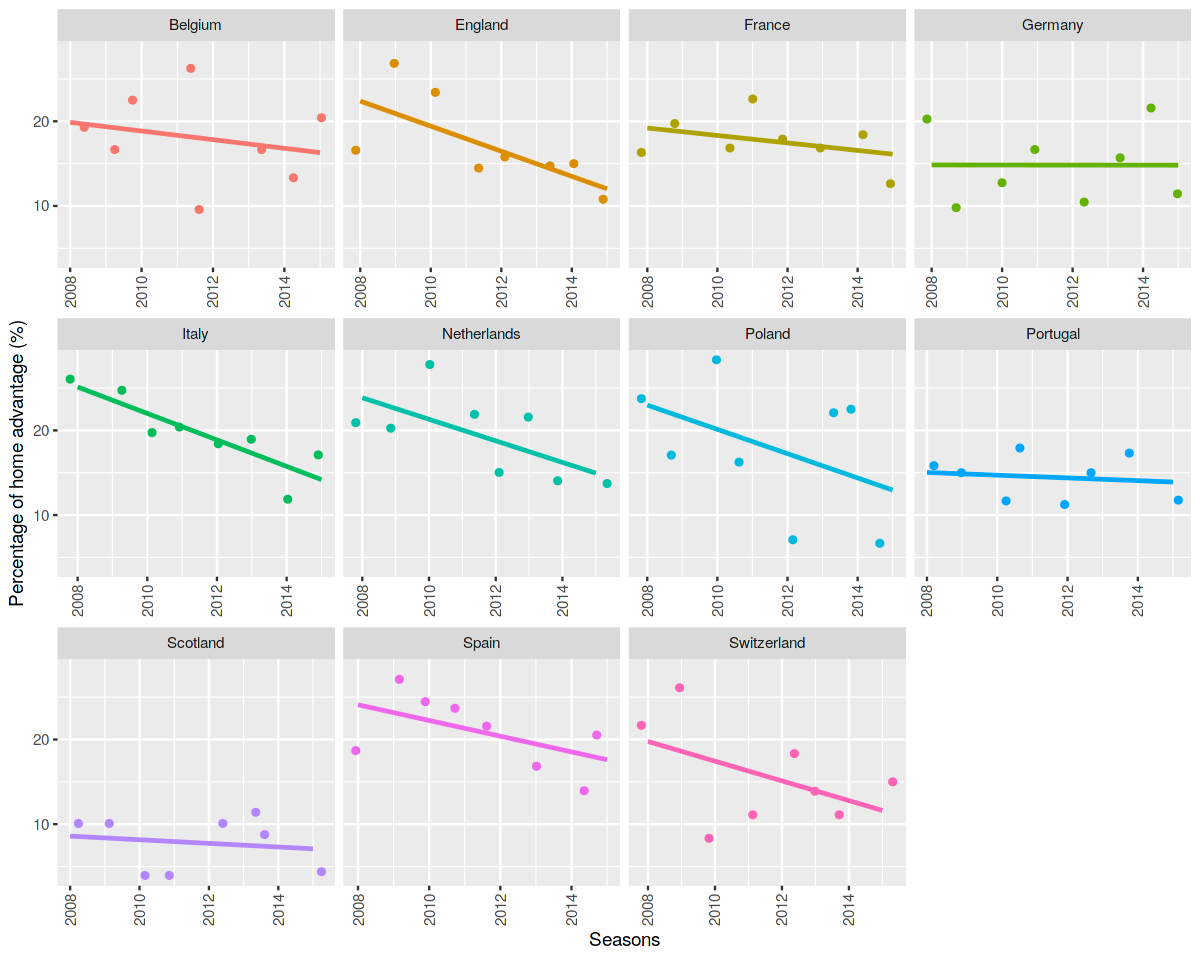

In [251]:
match$year =  as.numeric(substr(match$season,1,4))
require(ggplot2)
require(reshape2)
ggplot(match) +
  geom_jitter(aes(year,home_adv, colour=country_name),) + 
  facet_wrap(~country_name, scales="free_x") +
  geom_smooth(aes(year,home_adv, colour=country_name), method=lm, se=FALSE) +
  labs(y = "Percentage of home advantage (%)", x = "Seasons")+
theme(legend.position = "none")+
 theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
options(repr.plot.width=5, repr.plot.height=8)